# COMPUTATIONAL FINANCE PROJECT

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.sparse import diags
import seaborn as sb
from scipy.linalg import lu
import pandas as pd
from scipy import linalg
import scipy.stats as ss
import math
import scipy.stats as sp
from scipy.linalg import solve_banded

### Trapezoidal rule
$$  \int_{0}^{T} r_u \,du \sim \bigl[\frac{r_0-r_T}{2} +\sum_{j=1}^{m-1}r_{j\Delta t} \bigr]\Delta t    $$
The trapezoidal rule is a method used to approximate definite integral, in this project i used that to compute the expectation of the interest rate between point 0 and t, with the goal of discounting coupons.


##### algotithm:
"expectR" input:

* b: "long term mean level" 
* a: "speed of reversion"
* r0: "level of r in t0"
* tv: "vector of increment in time" 




"expectR" output:
* return a vector of expectation of the interest rate in each time t

"trapez" input:
* the same as "expectR" 
* the final time T 

"trapez" output:
* return an expectation of the integral between t0 and t in every t


In [56]:
def trapez(T,r0,a,b,dt):
    tv=np.arange(0,T,dt)
    rr=expectR(r0,a,tv[1:-1],b)
    rr=rr.sum()
    return ((r0+expectR(r0,a,T,b))/2+rr)*dt

In [57]:
def expectR(r0,a,tv,b):
    return r0*np.exp(-a*tv)+b*(1-np.exp(-a*tv))

### LCG/Box-Muller
Those are 2 algorithm to create list of pseudo-random numbers uniformely (LCG) or normally (Box-Muller) distributed.
I implemented those algorithms but i found out that numpy.random.normal is faster, so i decided to use that in my code.

In [58]:
def rn_generator(n,seed,uni=True):

    #LGD random U series
    a=40692
    m=2147483399
    x=[seed]
    u=[seed/m]
    t=np.linspace(0,1,n)
    for i in range(1,n):
        x.append((a*x[i-1])%m)
        u.append(x[i]/m)
    u1=np.array(u[0:n//2])
    u2=np.array(u[n//2:])

    #BOX-Muller random N series
    module=np.sqrt(-2*np.log(u1))
    alpha=2 * np.pi * u2
    n1=module*np.cos(alpha)
    n2=module*np.sin(alpha)
    if uni==True:
        return np.concatenate((n1,n2),axis=0)
    else:
        return n1,n2

## Vasicek
$$ dr_t=a(b-r_t)dt+\sigma dW_t^r                   $$
$$ E[r_t|r_0]=r_0 e^{-at} +b(1-e^{-at})                    $$
vasicek model is the one i used to model the evolution of interest rate, and the expectation toghether with application of trapezoidal rule is been usefull to discount coupons.

"vasicek" input:
* the same that we used to compute vasicek expectation
* the number of simulation "sim"
* the increment in time "dt"
* the istantaneous volatility "sigma"
* the matrix of correlated normally distributed r.n "epsilon_corr"
* another matrix of correlated normally distributed r.n "epsilon_corr_antithetic" for the variance reduction




"vasicek" output:
* a matrix of the dynamic of interest rate in each simulation
* a matrix of the dynamic of interest rate in each simulation for the antithetic variable
* a matrix of the dynamic of interest rate in each simulation with the application of the var. reduction

In [59]:
def vasicek(tv,sim,r0,a,b,dt,sigma,epsilon_corr,epsilon_corr_antithetic):
    rsim=np.ones((len(tv),sim))
    rsim[0,:]=r0
    rsim_antithetic=np.ones((len(tv),sim))
    rsim_antithetic[0,:]=r0

    for i in range(1,len(tv)):
        rsim[i,:]=rsim[i-1,:]+a*(b-rsim[i-1,:])*dt+sigma*np.sqrt(dt)*epsilon_corr[6,i*sim:(i+1)*sim]
        rsim_antithetic[i,:]=rsim_antithetic[i-1,:]+a*(b-rsim_antithetic[i-1,:])*dt+sigma*np.sqrt(dt)*epsilon_corr_antithetic[6,i*sim:(i+1)*sim]

    rsim_var_red=(rsim+rsim_antithetic)/2
    return rsim,rsim_var_red,rsim_antithetic

## Heston

#### Heston's volatility 

in the heston model the volatility is stochastic and it's modelled as a mean-reverting process 

$$ dv_t=K(\theta-v_t)dt+\lambda\sqrt{v_t}  dW_t^v                    $$
 $$ E[v_t|v_0]=v_0 e^{-\theta t} +K(1-e^{-\theta t})                    $$

"vol_heston" input:
* number of stock
* theta: "long term mean level" 
* k: "speed of reversion"
* lambda: "volartility of volatility"
* tv: "vector of increment in time" 
* v0: vector of initial volatility for each stock 
* series of random number, "epsilon_corr" and "epsilon_corr_antithetic"

"vol_heston" output:

* a tensor of the dynamic of volatility in each simulation for each stock
* a tensor of the dynamic of volatility in each simulation for each stock for the antithetic variable
* a tensor of the dynamic of volatility in each simulation for each stock with the application of the var. reduction

In [60]:
def vol_heston(stock,tv,dt,sim,k,theta,Lambda,v0,epsilon_corr,epsilon_corr_antithetic):


    Vsim=np.ones((len(tv),sim,3))
    Vsim[0,:,0]=v0[0]
    Vsim[0,:,1]=v0[1]
    Vsim[0,:,2]=v0[2]

    Vsim_antithetic=np.ones((len(tv),sim,3))
    Vsim_antithetic[0,:,0]=v0[0]
    Vsim_antithetic[0,:,1]=v0[1]
    Vsim_antithetic[0,:,2]=v0[2]

    for j in range(assetnumber):
        for i in range(1,len(tv)):
            Vsim[i,:,j]=abs(Vsim[i-1,:,j]+k[j]*(theta[j]-Vsim[i-1,:,j])*dt+Lambda[j]*np.sqrt(Vsim[i-1,:,j])*np.sqrt(dt)*epsilon_corr[3+j,i*sim:(i+1)*sim])
            Vsim_antithetic[i,:,j]=abs(Vsim_antithetic[i-1,:,j]+k[j]*(theta[j]-Vsim_antithetic[i-1,:,j])*dt+Lambda[j]*np.sqrt(Vsim_antithetic[i-1,:,j])*np.sqrt(dt)*epsilon_corr_antithetic[3+j,i*sim:(i+1)*sim])

    Vsim_var_red=(Vsim+Vsim_antithetic)/2
    return Vsim,Vsim_var_red,Vsim_antithetic

#### Heston's price evolution
by applying the stochastic volatility to that process i could use the heston model to simulate the path of the price of my underlyings
$$ dS_t=\mu S_t dt + \sqrt{v_t} S_t dW_t^s$$


"heston" input:
* a vector of initial price of each stock "s0"
* vector of time tv
* dt 
* n° of simulation "sim"
* the matrix of interest rate evolution and its anthitetic version
* the matrix of volatility evolution and its anthitetic version
* series of random number "epsilon_corr" and "epsilon_corr_antithetic" 

"heston" output:

* a tensor of the dynamic of stock's price in each simulation for each stock
* a tensor of the dynamic of stock's price in each simulation for each stock with the application of the var. reduction


In [61]:
def heston(s0,tv,dt,sim,rsim,rsim_antithetic,Vsim,Vsim_antithetic,epsilon_corr,epsilon_corr_antithetic):

    Ssim=np.ones((len(tv),sim,3))
    Ssim[0,:,0]=s0[0]
    Ssim[0,:,1]=s0[1]
    Ssim[0,:,2]=s0[2]

    Ssim_antithetic=np.ones((len(tv),sim,3))
    Ssim_antithetic[0,:,0]=s0[0]
    Ssim_antithetic[0,:,1]=s0[1]
    Ssim_antithetic[0,:,2]=s0[2]

    for j in range(assetnumber):
        for i in range(1,len(tv)):
            Ssim[i,:,j]=Ssim[i-1,:,j]+(rsim[i-1,:]*Ssim[i-1,:,j])*dt+np.sqrt(Vsim[i-1,:,j])*Ssim[i-1,:,j]*np.sqrt(dt)*epsilon_corr[j,i*sim:(i+1)*sim]
            Ssim_antithetic[i,:,j]=Ssim_antithetic[i-1,:,j]+(rsim_antithetic[i-1,:]*Ssim_antithetic[i-1,:,j])*dt+np.sqrt(Vsim_antithetic[i-1,:,j])*Ssim_antithetic[i-1,:,j]*np.sqrt(dt)*epsilon_corr_antithetic[j,i*sim:(i+1)*sim]
        
    Ssim_var_red=(Ssim_antithetic+Ssim)/2
    return Ssim,Ssim_var_red

## payment_grid
i used this function to define the stream of payments of the contract i've to price, it's characteristic are:

* nominal = 1000
* coupons = 25
* T = 5, the contract ends after 5 years.
* coupons frequency = 3 months
* the coupon are paid when the value of the 3 underlyins contemporary more than 50% of their initial value at the coupons payment date.
* memory effect = if coupons have not been paid in previous dates, the first time that condition to pay the coupon are gonna be met the contract is going to pay the coupon plus all coupons that didn't paid in previous dates.
* anticipated end = if in a coupon payment date the 3 underlyings worth contemporary more than 100% of their initial value, the contract ends paying the coupon and the nominal.
* moltiplicator of an underlying = nominal/initial value
* if in the date of automatic end of the contract T=5 the 3 underlyings worth contemporary more than 50% of their value in t=0, the contract ends paying the coupon and the nominal, instead if the value of at least one underlying is less than 50% of its initial value, the contact ends paying the final price of the asset with the worst performance multiplied by its moltiplicator

"payment_grid" input:
* n° of simulation
* time vector "tv"
* tensor of the dynamic of stock's price in each simulation for each stock
* vector of initial price "s0"

"payment_grid" output:
* "somma_t" is the dynamic of the average payment of the certificate
* "grid_of_payments" is the matrix of payment for each time of each simulation 
* "avg_coupon" is the vector of the number of coupon paid in each simulation


In [62]:
def payment_grid(sim,tv,Ssim,s0):
    grid_of_payments=np.zeros((sim,len(tv)))
    list_of_skip=[]
    memory_effect=np.ones(sim)
    avg_coupon=np.zeros(sim)
    N=1000
    C=25
    for i in range(0,len(tv),90):
        for j in range(sim):

            if j in list_of_skip:

                continue
            else:

                if  Ssim[i,j,0]<s0[0] or Ssim[i,j,1]<s0[1] or Ssim[i,j,2]<s0[2]:
                    if i !=1710:

                
                        if  Ssim[i,j,0]>0.5*s0[0] and Ssim[i,j,1]>0.5*s0[1] and Ssim[i,j,2]>0.5*s0[2] :

                            grid_of_payments[j,i]=C*memory_effect[j]
                            C=25
                            memory_effect[j]=1
                            avg_coupon[j]+=1

                        elif Ssim[i,j,0]<0.5*s0[0] or Ssim[i,j,1]<0.5*s0[1] or Ssim[i,j,2]<0.5*s0[2] :

                            memory_effect[j]=memory_effect[j]+1

                    elif i==1710:

                        if  Ssim[i,j,0]>0.5*s0[0] and Ssim[i,j,1]>0.5*s0[1] and Ssim[i,j,2]>0.5*s0[2] :

                            grid_of_payments[j,i]=C*memory_effect[j]
                            C=25
                            memory_effect[j]=1
                            avg_coupon[j]+=1

                        elif Ssim[i,j,0]<0.5*s0[0] or Ssim[i,j,1]<0.5*s0[1] or Ssim[i,j,2]<0.5*s0[2] :

                            memory_effect[j]=memory_effect[j]+1

                        if Ssim[-1,j,0]>0.5*s0[0] and Ssim[-1,j,1]>0.5*s0[1] and Ssim[-1,j,2]>0.5*s0[2]:

                            grid_of_payments[j,-1]=C*memory_effect[j]+N  
                            avg_coupon[j]+=1*memory_effect[j]


                        else:
                            var_stock1=(s0[0]-Ssim[-1,j,0])/s0[0]
                            var_stock2=(s0[1]-Ssim[-1,j,1])/s0[1]
                            var_stock3=(s0[2]-Ssim[-1,j,2])/s0[2]
                            m1=N/s0[0]
                            m2=N/s0[1]
                            m3=N/s0[2]

                            if var_stock1==max(var_stock1,var_stock2,var_stock3):
                                grid_of_payments[j,-1]=Ssim[-1,j,0]*m1

                
                            elif var_stock2==max(var_stock1,var_stock2,var_stock3):
                                grid_of_payments[j,-1]=Ssim[-1,j,1]*m2

                            else:
                                grid_of_payments[j,-1]=Ssim[-1,j,2]*m3
                elif Ssim[i,j,0]>s0[0] and Ssim[i,j,1]>s0[1] and Ssim[i,j,2]>s0[2] and i!=0:
                    if i<93:
                        grid_of_payments[j,i]=C
                        avg_coupon[j]+=1

                    else:
                        grid_of_payments[j,i]=C*memory_effect[j]+N
                        avg_coupon[j]+=1
                        list_of_skip.append(j)
                

    somma_t=(grid_of_payments/sim).sum(axis=0)
    return somma_t,grid_of_payments,avg_coupon

## price_and_list
this function take in imput the vector of expected payment for each date "somma_t", compute a vector of discount for every dt and discount the expected payment in each date with the result of a vector of expected discounted payment for each date. After that sum all value and obtain the price of the certificate.

"price_and_list" input:
* the dynamic of the average payment of the certificate "somma_t" 

"price_and_list" output:
* the price of the certificate "price"
* the vector of discounted average payment "pricing_list1"
* the vector of dicount factor "pricing_list"

In [63]:
def price_and_list(somma_t):
    a=0
    pricing_list=[]
    for i in tv:

        pricing_list.append(np.exp(-trapez(i,r0,a,b,dt)))
    
        a=a+1
    pricing_list=np.array(pricing_list)
    pricing_list1=pricing_list*somma_t


    price=pricing_list1.sum()

    return price,pricing_list1,pricing_list


## Data
i didn't calibrate my model so i considered the data already given.

In [64]:
np.random.seed(86)
sim=10000
b=0.06
a=0.4
sigma=0.07
r0=0.02
T=5
dt=1/360
tv=np.arange(0,T,dt)
assetnumber=3
n_plot=200
stock=['pirelli','moncler','bpm']

k1=0.5
k2=0.38
k3=0.45
k=[k1,k2,k3]

theta1=0.33**2
theta2=0.4**2
theta3=0.35**2
theta=[theta1,theta2,theta3]

Lambda1=0.2
Lambda2=0.34
Lambda3=0.27
Lambda=[Lambda1,Lambda2,Lambda3]

v01=0.25**2
v02=0.3**2
v03=0.2**2
v0=[v01,v02,v03]

s01=4.488
s02=62.5
s03=3.84

s0=[s01,s02,s03]

rhos12=0.23
rhos13=0.12
rhos1v1=-0.3
rhos1v2=0.05
rhos1v3=0.03
rhos1r=0.25
rhos23=0.2
rhos2v1=0.04
rhos2v2=-0.5
rhos2v3=0.09
rhos2r=0.34
rhos3v1=0.03
rhos3v2=0.06
rhos3v3=-0.1
rhos3r=0.11
rhorv1=-0.3
rhorv2=-0.21
rhorv3=-0.42
rhov1v2=0.15
rhov1v3=0.2
rhorv2v3=0.09

delta=np.zeros((7,7))

delta[0,1]=rhos12
delta[0,2]=rhos13
delta[0,3]=rhos1v1
delta[0,4]=rhos1v2
delta[0,5]=rhos1v3
delta[0,6]=rhos1r
delta[1,2]=rhos23
delta[1,3]=rhos2v1
delta[1,4]=rhos2v2
delta[1,5]=rhos2v3
delta[1,6]=rhos2r
delta[2,3]=rhos3v1
delta[2,4]=rhos3v2
delta[2,5]=rhos3v3
delta[2,6]=rhos3r
delta[3,4]=rhov1v2
delta[3,5]=rhov1v3
delta[3,6]=rhorv1
delta[4,5]=rhorv2v3
delta[4,6]=rhorv2
delta[5,6]=rhorv3

delta1=delta.T
delta=delta+delta1

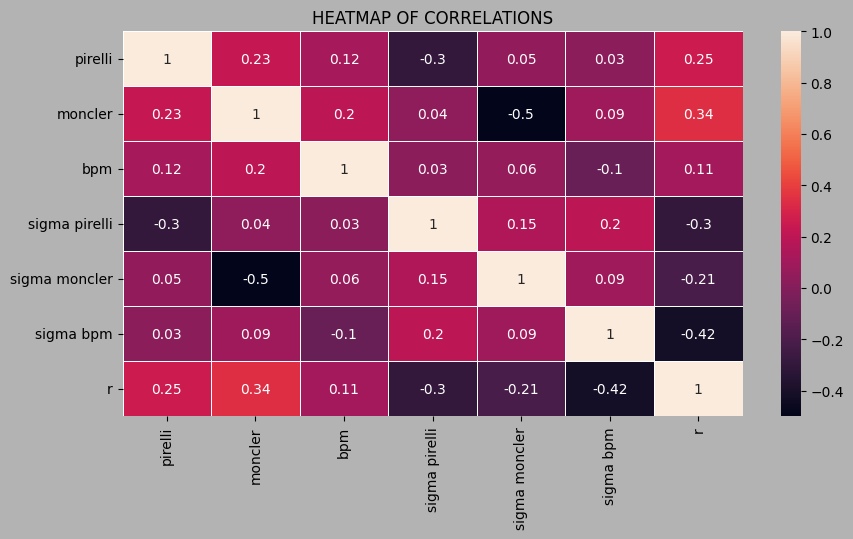

In [65]:
# correlation matrix

for i in range(7):
    delta[i,i]=1
delta=pd.DataFrame({'pirelli': delta[0,:],
                    'moncler': delta[1,:],
                    'bpm': delta[2,:],
                    'sigma pirelli': delta[3,:],
                    'sigma moncler': delta[4,:],
                    'sigma bpm': delta[5,:],
                    'r': delta[6,:]
                    },index=['pirelli','moncler','bpm','sigma pirelli','sigma moncler','sigma bpm','r'])

fig,ax=plt.subplots(facecolor=".7",figsize=(10, 5))
ax.set_title('HEATMAP OF CORRELATIONS')
sb.heatmap(delta,annot=True,linewidth=.5)
delta=delta.values

## introducing the correlation structure in the model
after defining all data and the correlations, i needed my pseudo-random number to respect the correlation structure, because they are iid between eachother as soos as simuated, so i applied a cholesky decomposition to the correlation matrix and i obtained a lower triangular matrix that allows me to introduce the correlation:

$$ dw_t\sim N(0,dt) \hspace{2ex} ,\hspace{2ex}    z\sim N(0,1) \hspace{2ex} ,\hspace{2ex}  dw_t=\sqrt{dt}z$$



$$\begin{vmatrix}
a_{11} & 0 & 0 & ...\\
a_{21} & a_{22} & 0 & ...\\
a_{31} & a_{32} & a_{33} & ...\\
... & ... & ... & ...\\
\end{vmatrix}$$

$$ \begin{align*}   z_{corr}^1 &=  a_{11}z^1    \\                                
   z_{corr}^2 &=  a_{21}z^1+    a_{22}z^2   \\                              
   z_{corr}^3 &=  a_{31}z^1+    a_{32}z^2  + a_{33}z^3      \\                         
  ...                       \end{align*}      $$
  $$  $$

  $$ dw_{corr}(t)=\sqrt{dt}z_{corr} $$  
  where z_corr is a vector of random variable normally distributed in (0,1) that respect the correlation structure 

In [66]:
#cholesky factorization and creating correlated epsilon 
    
L=np.linalg.cholesky(delta)
random=np.random.normal(size=(assetnumber*sim*len(tv)*2+sim*len(tv))*2)

random_series=random[:assetnumber*sim*len(tv)*2+sim*len(tv)]
random_series_antithetic=-random[assetnumber*sim*len(tv)*2+sim*len(tv):]

epsilon=np.ones((assetnumber*2+1,sim*len(tv)))
epsilon_antithetic=np.ones((assetnumber*2+1,sim*len(tv)))
epsilon_corr=epsilon
epsilon_corr_antithetic=epsilon_antithetic

aux_array=np.zeros_like(epsilon[1,:])
aux_array_antithetic=np.zeros_like(epsilon_antithetic[1,:])

for i in range((assetnumber*2+1)):
    epsilon[i,:]=random_series[i*sim*len(tv):(i+1)*sim*len(tv)]
    epsilon_antithetic[i,:]=random_series_antithetic[i*sim*len(tv):(i+1)*sim*len(tv)]

for i in range(len(delta[1,:])):
    aux_array_antithetic=aux_array_antithetic*0
    aux_array=aux_array*0
    for j in range(len(delta[1,:])):
        aux_array=aux_array+epsilon[i,:]*L[i,j]
        aux_array_antithetic=aux_array_antithetic+epsilon_antithetic[i,:]*L[i,j]
    epsilon_corr[i,:]= aux_array  
    epsilon_corr_antithetic[i,:]= aux_array_antithetic  


## antithetic variates
The antithetic variate is a variance reduction method appliable to symmetric distributions.
$$ z^1 \sim N(0,1) \hspace{2ex} ,\hspace{2ex}   z^2\sim N(0,1)$$
$$ f(z^1)=y \hspace{2ex} ,\hspace{2ex}     f(-z^2)= y^a$$
$$ y^{Var Red}=\frac{y+y^a}{2}$$

## simulations 
in the next 6 blocks of code i simulated using previous functions 10000 possible path for the interest rate and for the price of the underlyings with and without the application of the variance reduction method, than i plotted both and compared eachother.

In [67]:
rsim,rsim_var_red,rsim_antithetic=vasicek(tv,sim,r0,a,b,dt,sigma,epsilon_corr,epsilon_corr_antithetic)

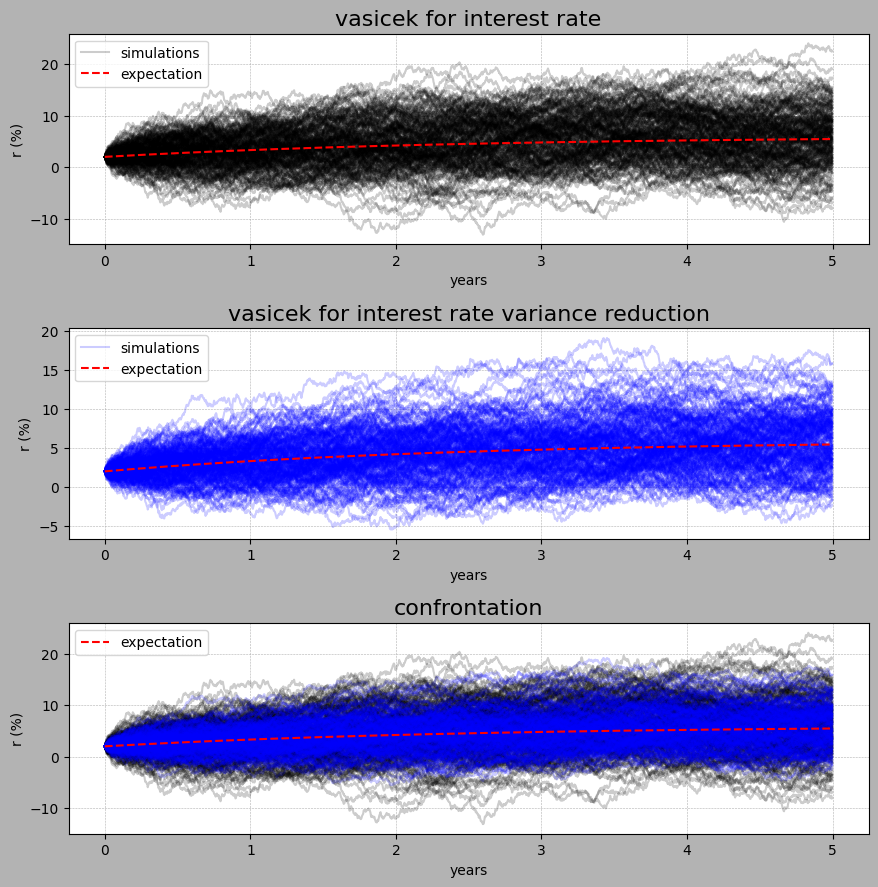

In [68]:

fig,ax=plt.subplots(3,facecolor=".7",figsize=(10, 10))

fig.tight_layout(pad=5.0)
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)

ax[0].plot(tv,rsim[:,1:n_plot]*100,'k',alpha=0.2)
ax[0].plot(tv,rsim[:,0]*100,'k',alpha=0.2,label='simulations')
ax[0].set_title('vasicek for interest rate',fontsize=16)
ax[0].grid(visible=1,linewidth=0.4,linestyle='--')
expectr= r0*np.exp(-a*tv)+b*(1-np.exp(-a*tv))
ax[0].plot(tv,expectr*100,'r--',label='expectation')
ax[0].set_xlabel('years')
ax[0].set_ylabel('r (%)')

ax[0].legend()


ax[1].plot(tv,rsim_var_red[:,0]*100,'b',alpha=0.2,label='simulations')
ax[1].plot(tv,rsim_var_red[:,1:n_plot]*100,'b',alpha=0.2)
ax[1].set_title('vasicek for interest rate variance reduction',fontsize=16)
ax[1].grid(visible=1,linewidth=0.4,linestyle='--')
expectr= r0*np.exp(-a*tv)+b*(1-np.exp(-a*tv))
ax[1].plot(tv,expectr*100,'r--',label='expectation')
ax[1].set_xlabel('years')
ax[1].set_ylabel('r (%)')
ax[1].legend()

ax[2].plot(tv,rsim[:,:n_plot]*100,'k',alpha=0.2)
ax[2].plot(tv,rsim_var_red[:,:n_plot]*100,'b',alpha=0.2)

ax[2].set_title('confrontation',fontsize=16)
ax[2].grid(visible=1,linewidth=0.4,linestyle='--')
expectr= r0*np.exp(-a*tv)+b*(1-np.exp(-a*tv))
ax[2].plot(tv,expectr*100,'r--',label='expectation')
ax[2].set_xlabel('years')
ax[2].set_ylabel('r (%)')
ax[2].legend()
plt.show()

In [69]:
Vsim,Vsim_var_red,Vsim_antithetic=vol_heston(stock,tv,dt,sim,k,theta,Lambda,v0,epsilon_corr,epsilon_corr_antithetic)

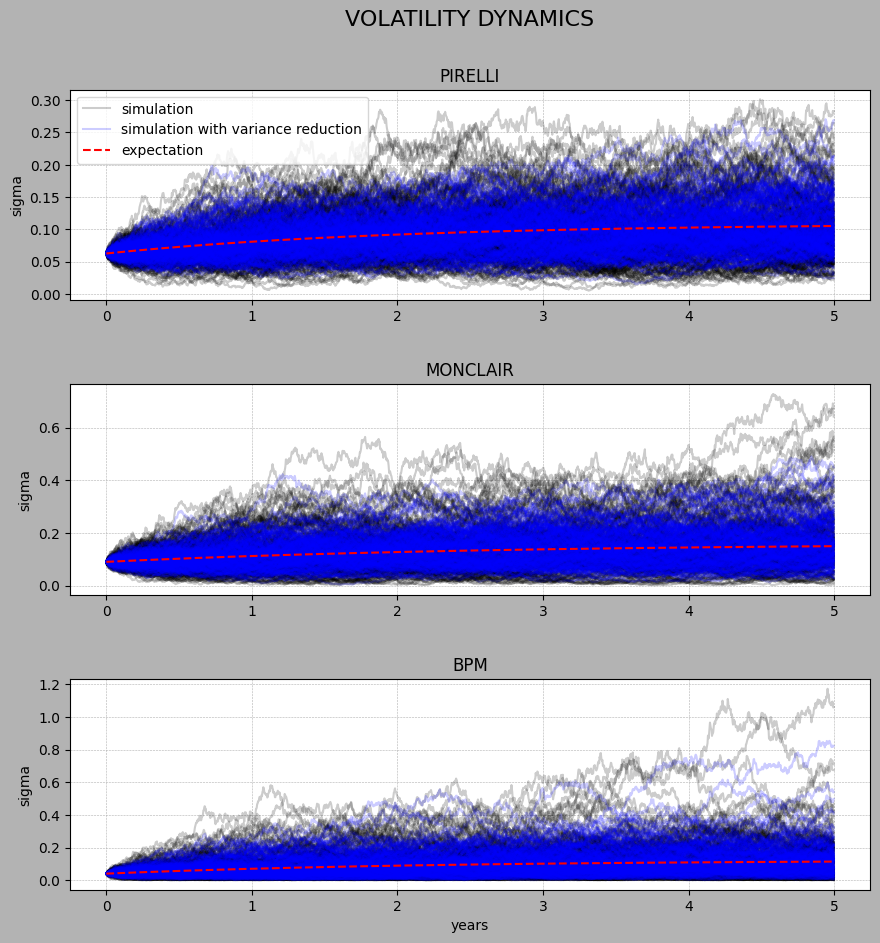

In [70]:
fig,(ax1,ax2,ax3)=plt.subplots(3,figsize=(10, 10),facecolor=".7")
fig.suptitle('VOLATILITY DYNAMICS', fontsize=16)
fig.tight_layout(pad=5.0)
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
expect1=v0[0]*np.exp(-k[0]*tv)+theta[0]*(1-np.exp(-k[0]*tv))
expect2=v0[1]*np.exp(-k[1]*tv)+theta[1]*(1-np.exp(-k[1]*tv))
expect3=v0[2]*np.exp(-k[2]*tv)+theta[2]*(1-np.exp(-k[2]*tv))
for j in range(assetnumber):

    if j==0:


        ax1.set_ylabel('sigma')
        ax1.set_title('PIRELLI')
        ax1.plot(tv,Vsim[:,0,j],'k',alpha=0.2,label='simulation')
        ax1.plot(tv,Vsim[:,1:n_plot,j],'k',alpha=0.2)
        ax1.plot(tv,Vsim_var_red[:,0,j],'b',alpha=0.2,label='simulation with variance reduction')
        ax1.plot(tv,Vsim_var_red[:,1:n_plot,j],'b',alpha=0.2)
        ax1.plot(tv,expect1,'r--',label='expectation')
        ax1.grid(visible=1,linewidth=0.4,linestyle='--')
        ax1.legend()

    elif j==1:


        ax2.set_ylabel('sigma')
        ax2.set_title('MONCLAIR')
        ax2.plot(tv,Vsim[:,:n_plot,j],'k',alpha=0.2)
        ax2.plot(tv,Vsim_var_red[:,:n_plot,j],'b',alpha=0.2)
        ax2.plot(tv,expect2,'r--')
        ax2.grid(visible=1,linewidth=0.4,linestyle='--')
    else:

        ax3.set_xlabel('years')
        ax3.set_ylabel('sigma')
        ax3.set_title('BPM')
        ax3.plot(tv,Vsim[:,:n_plot,j],'k',alpha=0.2)
        ax3.plot(tv,Vsim_var_red[:,:n_plot,j],'b',alpha=0.2)
        ax3.grid(visible=1,linewidth=0.4,linestyle='--')
        ax3.plot(tv,expect3,'r--')

In [71]:
Ssim,Ssim_var_red=heston(s0,tv,dt,sim,rsim,rsim_antithetic,Vsim,Vsim_antithetic,epsilon_corr,epsilon_corr_antithetic)

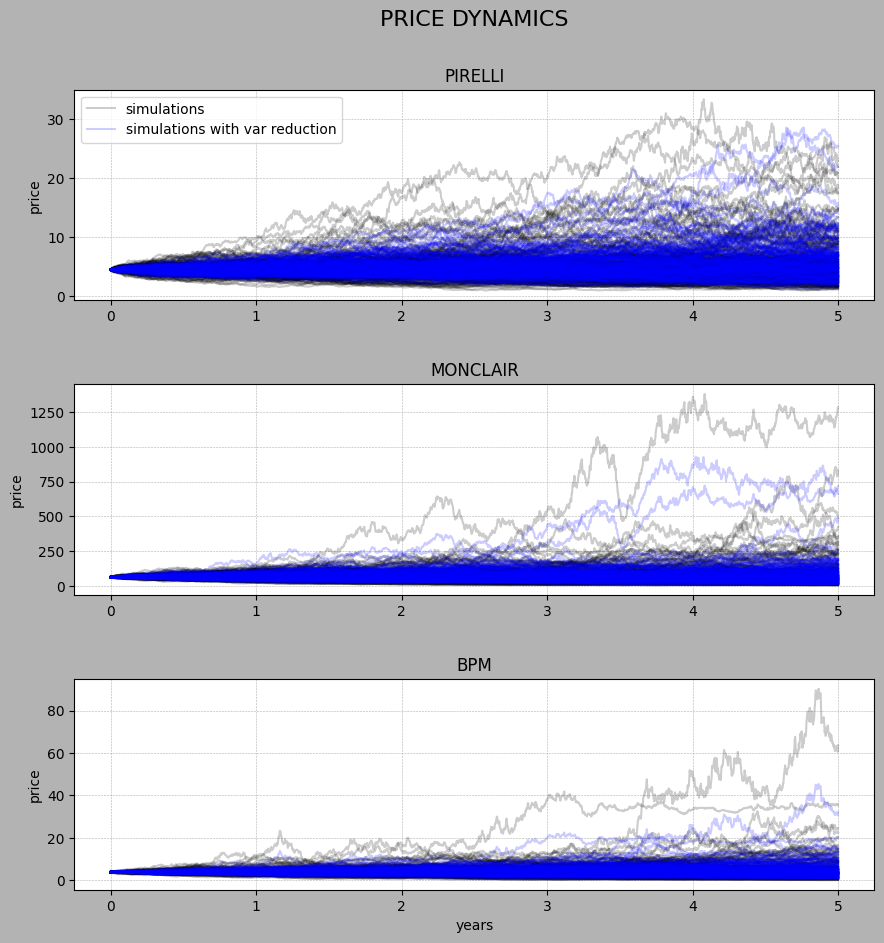

In [72]:
fig,(ax1,ax2,ax3)=plt.subplots(3,figsize=(10, 10),facecolor=".7")
fig.suptitle('PRICE DYNAMICS', fontsize=16)
fig.tight_layout(pad=5.0)
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
for j in range(assetnumber):

    if j==0:


        ax1.set_ylabel('price')
        ax1.set_title('PIRELLI')
        ax1.plot(tv,Ssim[:,0,j],'k',alpha=0.2,label='simulations')
        ax1.plot(tv,Ssim[:,1:n_plot,j],'k',alpha=0.2)
        ax1.plot(tv,Ssim_var_red[:,0,j],'b',alpha=0.2,label='simulations with var reduction')
        ax1.plot(tv,Ssim_var_red[:,1:n_plot,j],'b',alpha=0.2)
        ax1.grid(visible=1,linewidth=0.4,linestyle='--')
        ax1.legend()

    elif j==1:


        ax2.set_ylabel('price')
        ax2.set_title('MONCLAIR')
        ax2.plot(tv,Ssim[:,:n_plot,j],'k',alpha=0.2)
        ax2.plot(tv,Ssim_var_red[:,:n_plot,j],'b',alpha=0.2)

        ax2.grid(visible=1,linewidth=0.4,linestyle='--')
    else:

        ax3.set_xlabel('years')
        ax3.set_ylabel('price')
        ax3.set_title('BPM')
        ax3.plot(tv,Ssim[:,:n_plot,j],'k',alpha=0.2)
        ax3.plot(tv,Ssim_var_red[:,:n_plot,j],'b',alpha=0.2)
        ax3.grid(visible=1,linewidth=0.4,linestyle='--')


In [73]:
somma_t,grid_of_payments,avg_coupon=payment_grid(sim,tv,Ssim,s0)
somma_t_var_red,grid_of_payments_var_red,avg_coupon_var_red=payment_grid(sim,tv,Ssim_var_red,s0)

In [74]:
price,pricing_list1,pricing_list=price_and_list(somma_t)
price_var_red,pricing_list1_var_red,pricing_list_var_red=price_and_list(somma_t_var_red)

### Analisis of the price
still using price_and_list function i obtained the graph of how much each payment date influences the final price, both for the normal simulation and the one with applied the variance reduction method, some block of code down we can see the same graph but in percentage.
what we can instantly notice is that except for first date where the contract can't finish and last date where the contract automatically ends the weight on the price of each coupon payment date is decreasing with time, because the increasing discount factor but also because the probability to find all 3 underlyings over 100% of their initial value. A conclusion is that the probability that contract pays the nominal is higher in lower t than in higher one.

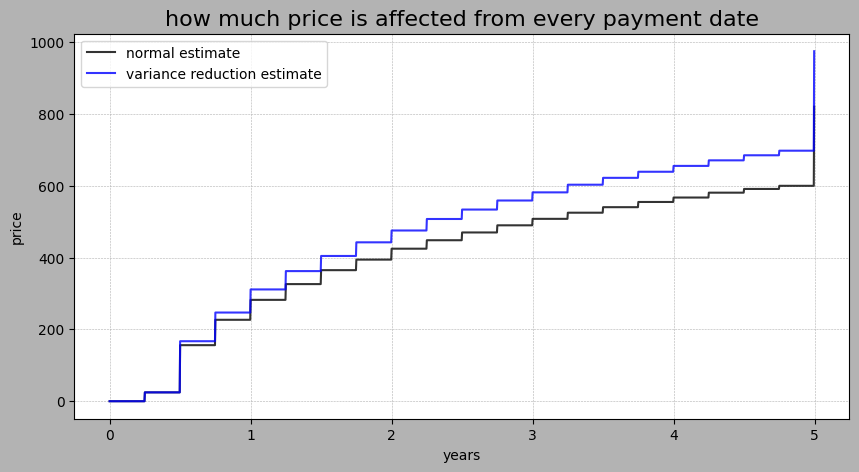

In [75]:
for_plt=np.cumsum(pricing_list1)
for_plt_var_red=np.cumsum(pricing_list1_var_red)
fig,ax=plt.subplots(facecolor=".7",figsize=(10, 5),sharex=True)

ax.plot(tv,for_plt,'k',alpha=0.8,label='normal estimate')
ax.plot(tv,for_plt_var_red,'b',alpha=0.8,label='variance reduction estimate')

ax.set_title('how much price is affected from every payment date',fontsize=16)
ax.grid(visible=1,linewidth=0.4,linestyle='--')

ax.set_xlabel('years')
ax.set_ylabel('price')
plt.legend()

plt.show()

In [76]:
pricing_list11=[]
for i in pricing_list1:
    if i!=0:
        pricing_list11.append(i)
pricing_list11=np.array(pricing_list11)

In [77]:
pricing_list11_var_red=[]
for i in pricing_list1_var_red:
    if i!=0:
        pricing_list11_var_red.append(i)
pricing_list11_var_red=np.array(pricing_list11_var_red)

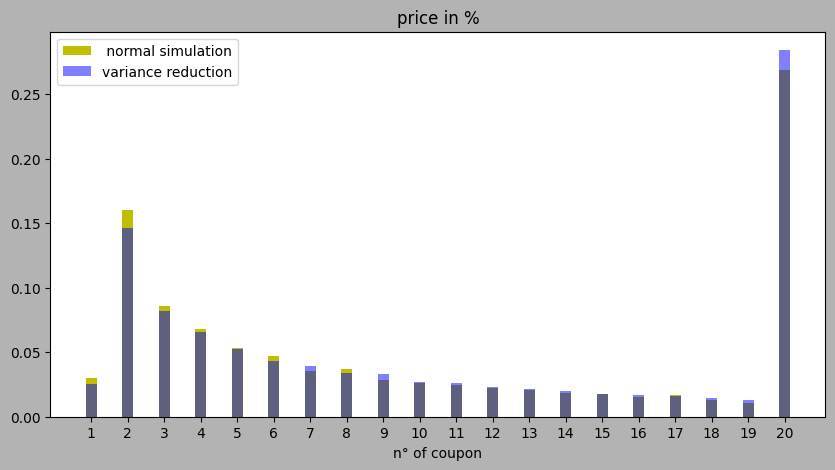

In [78]:
fig,ax=plt.subplots(facecolor=".7",figsize=(10, 5))
x = range(1,21)
default_x_ticks = range(len(x))
plt.xticks(default_x_ticks, x)


width = 0.3 

p2 = plt.bar(range(20), pricing_list11/price, width, color='y', label=' normal simulation')
p1 = plt.bar(range(20), pricing_list11_var_red/price_var_red, width, color='b',label='variance reduction',alpha=0.5)

plt.xlabel('n° of coupon')
plt.title('price in %')

plt.legend()

plt.show()


a consequence of the reduction of the variance is that the early dates influence less, with respect the normal simulation, the price. this is because a lower variance bring us to a lower chanche of early redemption of the contract with all 3 underlyings over 100%, direct consequence of that is that in the variance reduction method the price is higher because are paid more coupons on average.

In [79]:
avg_coupon=sum(avg_coupon)
avg_coupon_var_red=sum(avg_coupon_var_red)

In [80]:
print('the average number of coupons paid for the simulations without variance reduction is:{} '.format(avg_coupon/sim) )
print('----')
print('the average number of coupons paid for the simulations with the variance reduction is:{} '.format(avg_coupon_var_red/sim) )

the average number of coupons paid for the simulations without variance reduction is:9.4181 
----
the average number of coupons paid for the simulations with the variance reduction is:11.304 


In [81]:
dynamic_of_price=[price]
dynamic_of_price_var_red=[price_var_red]
for i in range(1,len(tv)):
    dynamic_of_price.append((pricing_list[:-i]*somma_t[i:]).sum())
    dynamic_of_price_var_red.append((pricing_list[:-i]*somma_t_var_red[i:]).sum())
dynamic_of_price=np.array(dynamic_of_price)
dynamic_of_price_var_red=np.array(dynamic_of_price_var_red)

stoch_price_dyn=np.ones((sim,len(tv)))
stoch_price_dyn[:,-1]=price
stoch_price_dyn_var_red=np.ones((sim,len(tv)))
stoch_price_dyn_var_red[:,-1]=price_var_red

for i in range(sim):
    for j in range(1,len(tv)):
        stoch_price_dyn[i,j]=(grid_of_payments[i,j:]*pricing_list[:-j]).sum()
        stoch_price_dyn_var_red[i,j]=(grid_of_payments_var_red[i,j:]*pricing_list[:-j]).sum()

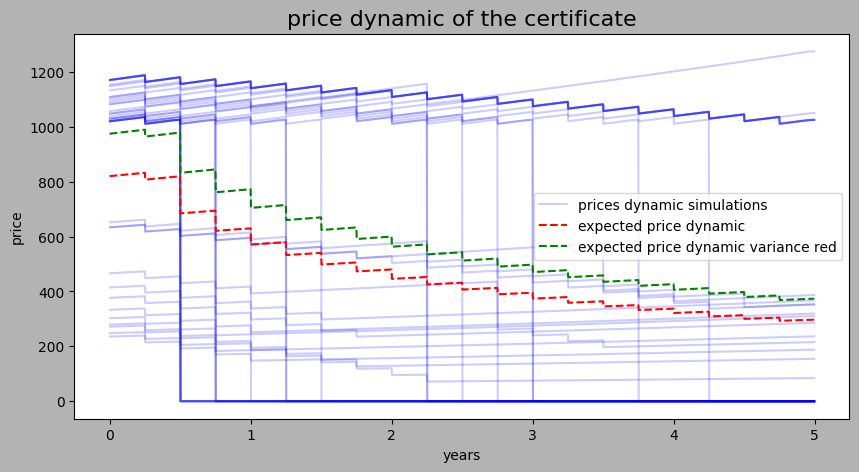

In [82]:
fig,ax=plt.subplots(facecolor=".7",figsize=(10, 5))

stoch_price_dyn=stoch_price_dyn.T
ax.plot(tv[1:],stoch_price_dyn[1:,1:40],'b',alpha=0.2)
ax.plot(tv[1:],stoch_price_dyn[1:,0],'b',alpha=0.2,label='prices dynamic simulations')

ax.plot(tv,dynamic_of_price,'r--',label='expected price dynamic')
ax.plot(tv,dynamic_of_price_var_red,'g--',label='expected price dynamic variance red')

ax.set_title('price dynamic of the certificate',fontsize=16)


ax.set_xlabel('years')
ax.set_ylabel('price')
ax.legend()

plt.show()

### error 
by computing the variance of the payments using my simulations and my average payments i can compute the error deriving from the montecarlo method, using the formula:
$$         \sqrt{        \frac{      \sigma _n ^2  }{n}    }                             $$


as we can see the variance reduction method, in the blocks of code below, in this case was not so effective.
considering that the computation power rquired by the varince reduction method is approximately the double than the normal one, a so little reduction of the error doesn't worth.
a more efficent way to obtain the same error reduction in this case would have been increasing the number of simulations of a number deriving from:
$$  VarRedEffect=\sqrt{\frac{ \sigma _{normal}  ^2  }{n}}  -  \sqrt{\frac{ \sigma _{Var Red}  ^2  }{n}} =\sqrt{\frac{ \sigma   ^2  }{n}} -\sqrt{\frac{ \sigma   ^2  }{n+\Delta n}}    $$

$$  VarRedEffect-\sqrt{\frac{ \sigma   ^2  }{n}}= -\sqrt{\frac{ \sigma   ^2  }{n+\Delta n}}  $$
$$  \sqrt{\frac{ \sigma   ^2  }{n}}-VarRedEffect= \sqrt{\frac{ \sigma   ^2  }{n+\Delta n}}  $$
$$  (\sqrt{\frac{ \sigma   ^2  }{n}}-VarRedEffect)^2= \frac{ \sigma   ^2  }{n+\Delta n}  $$

$$  n+\Delta n=  \frac{ \sigma   ^2  }{(\sqrt{\frac{ \sigma   ^2  }{n}}-VarRedEffect)^2}$$

$$ \frac{ \sigma   ^2  }{(\sqrt{\frac{ \sigma   ^2  }{n}}-VarRedEffect)^2}-n=\Delta n \sim 2361     $$


using variance reduction is needed an increment in the computation effort of approximately 100% to obtain a reduction of MC error equal to VarRedEffect.
simply incrementing the number of simulation is needed an increment in the computation effort of approximately 23.61% to obtain the same result than the one obtained by the variance reduction method with antithetic variable.

In [83]:
var=(grid_of_payments-somma_t)/somma_t
var[np.isnan(var)]=0
var=np.sum(var**2,axis=0)/sim
var=sum(var)/(len(tv)-1)
error=np.sqrt(var/sim)

var_var_red=(grid_of_payments_var_red-somma_t_var_red)/somma_t_var_red
var_var_red[np.isnan(var_var_red)]=0
var_var_red=np.sum(var_var_red**2,axis=0)/sim
var_var_red=sum(var_var_red)/(len(tv)-1)
error_var_red=np.sqrt(var_var_red/sim)

#---------------------------------------------------------------------------------------------------------------------------
#the error down here is given from the fact that in my code there are some division by zero and the 
# program substitute those value with "Nan", i keeped that in count so the error below doesn't affect in any way the result 
#---------------------------------------------------------------------------------------------------------------------------

/var/folders/kc/4tv45m2j1llfjkv_fvz_tv8m0000gn/T/ipykernel_41854/218919962.py:1: RuntimeWarning: invalid value encountered in true_divide
  var=(grid_of_payments-somma_t)/somma_t
/var/folders/kc/4tv45m2j1llfjkv_fvz_tv8m0000gn/T/ipykernel_41854/218919962.py:7: RuntimeWarning: invalid value encountered in true_divide
  var_var_red=(grid_of_payments_var_red-somma_t_var_red)/somma_t_var_red


In [84]:
print('std is ',np.sqrt(var),'MC error is ',error)
print()
print('with variance reduction std is ',np.sqrt(var_var_red),'MC error is ',error_var_red)

std is  0.47657626211175547 MC error is  0.004765762621117555

with variance reduction std is  0.4286500154478929 MC error is  0.004286500154478928


In [85]:
varredeffect=error-error_var_red
n_high=var/((-varredeffect+np.sqrt(var/sim))**2)
n_high-sim

2361.157098768321

## Greeks
to comute an approximation of greeks it's enough to compute again the pricing function with respect to an increment and a decrement and than apply the central difference formula for derivatives:
$$\frac{df}{dx}=\frac{f((x+\Delta h),y,z,...)-f((x-\Delta h),y,z,...)}{2\Delta h}  $$
$$\frac{d^2f}{dx^2}=\frac{f((x+\Delta h),y,z,...)-2f(x,y,z,...)+f((x-\Delta h),y,z,...)}{\Delta h^2}  $$
where x,y,z,.. are the variable of my pricing function and x is the variable with respect to whom i derive (underlying price, volatility, ecc.), the result is the partial derivative with respect to that variable and we can read the result as the effect on price of an increment of that variable.

In [86]:
rup=r0+0.01
rdown=r0-0.01

In [87]:
rsim_up,rsim_var_red_up,rsim_antithetic_up=vasicek(tv,sim,rup,a,b,dt,sigma,epsilon_corr,epsilon_corr_antithetic)
rsim_down,rsim_var_red_down,rsim_antithetic_down=vasicek(tv,sim,rdown,a,b,dt,sigma,epsilon_corr,epsilon_corr_antithetic)

Ssim_up_r,Ssim_var_red_up_r=heston(s0,tv,dt,sim,rsim_up,rsim_antithetic_up,Vsim,Vsim_antithetic,epsilon_corr,epsilon_corr_antithetic)
Ssim_down_r,Ssim_var_red_down_r=heston(s0,tv,dt,sim,rsim_down,rsim_antithetic_down,Vsim,Vsim_antithetic,epsilon_corr,epsilon_corr_antithetic)
somma_t_rup,grid_of_payments_rup,_=payment_grid(sim,tv,Ssim_var_red_up_r,s0)
somma_t_rdown,grid_of_payments_rdown,_=payment_grid(sim,tv,Ssim_var_red_down_r,s0)

price_rup,pricing_list1_rup,pricing_list_rup=price_and_list(somma_t_rup)
price_rdown,pricing_list1_rdown,pricing_list_rdown=price_and_list(somma_t_rdown)

In [88]:
rho_g=(price_rup-price_rdown)/(2*0.01)

In [89]:

vega=[]
for i,el in enumerate(v0):
    v_up=[v01,v02,v03]
    v_down=[v01,v02,v03]
    v_up[i]=el+0.01
    v_down[i]=el-0.01
    Vsim_up,Vsim_var_red_up,Vsim_antithetic_up=vol_heston(stock,tv,dt,sim,k,theta,Lambda,v_up,epsilon_corr,epsilon_corr_antithetic)
    Vsim_down,Vsim_var_red_down,Vsim_antithetic_down=vol_heston(stock,tv,dt,sim,k,theta,Lambda,v_down,epsilon_corr,epsilon_corr_antithetic)


    Ssim_up,Ssim_var_red_up=heston(s0,tv,dt,sim,rsim,rsim_antithetic,Vsim_up,Vsim_antithetic_up,epsilon_corr,epsilon_corr_antithetic)
    Ssim_down,Ssim_var_red_down=heston(s0,tv,dt,sim,rsim,rsim_antithetic,Vsim_down,Vsim_antithetic_down,epsilon_corr,epsilon_corr_antithetic)

    somma_t_vup,grid_of_payments_vup,_=payment_grid(sim,tv,Ssim_var_red_up,s0)
    somma_t_vdown,grid_of_payments_vdown,_=payment_grid(sim,tv,Ssim_var_red_down,s0)

    price_vup,pricing_list1_vup,pricing_list_vup=price_and_list(somma_t_vup)
    price_vdown,pricing_list1_vdown,pricing_list_vdown=price_and_list(somma_t_vdown)
    vega.append((price_vup-price_vdown)/(2*0.01))


In [90]:
delta_g=[]
gamma_g=[]
for i,el in enumerate(s0):
    s_up=[s01,s02,s03]
    s_down=[s01,s02,s03]
    s_up[i]=el+0.01*el
    s_down[i]=el-0.01*el

    Ssim_up,Ssim_var_red_up=heston(s_up,tv,dt,sim,rsim,rsim_antithetic,Vsim,Vsim_antithetic,epsilon_corr,epsilon_corr_antithetic)
    Ssim_down,Ssim_var_red_down=heston(s_down,tv,dt,sim,rsim,rsim_antithetic,Vsim,Vsim_antithetic,epsilon_corr,epsilon_corr_antithetic)

    somma_t_sup,grid_of_payments_sup,_=payment_grid(sim,tv,Ssim_var_red_up,s0)
    somma_t_sdown,grid_of_payments_down,_=payment_grid(sim,tv,Ssim_var_red_down,s0)

    price_sup,pricing_list1_sup,pricing_list_up=price_and_list(somma_t_sup)
    price_sdown,pricing_list1_down,pricing_list_down=price_and_list(somma_t_sdown)

    gamma_g.append((price_sup-2*price_var_red+price_sdown)/((0.01*el)**2))
    delta_g.append((price_sup-price_sdown)/(2*0.01*el))

In [91]:
bns_vol=np.ones_like(Vsim)*theta
bns_vol_ant=np.ones_like(Vsim)*theta
bns_dyn,bns_dyn_var_red=heston(s0,tv,dt,sim,rsim,rsim_antithetic,bns_vol,bns_vol_ant,epsilon_corr,epsilon_corr_antithetic)
bns_dyn=np.array(bns_dyn)
bns_dyn_var_red=np.array(bns_dyn_var_red)


In [92]:
somma_t_bns,grid_of_payments_bns,_=payment_grid(sim,tv,bns_dyn,s0)
somma_t_var_red_bns,grid_of_payments_var_red_bns,_=payment_grid(sim,tv,bns_dyn_var_red,s0)

In [93]:
price_bns,pricing_list1_bns,pricing_list_bns=price_and_list(somma_t_bns)
price_var_red_bns,pricing_list1_var_red_bns,pricing_list_var_red_bns=price_and_list(somma_t_var_red_bns)

In [94]:
greeks=pd.DataFrame({'delta_pirelli': delta_g[0]*0.01,
                    'delta_moncler': delta_g[1]*0.01,
                    'delta_bpm': delta_g[2]*0.01,
                    'gamma_pirelli': gamma_g[0]*0.0001,
                    'gamma_moncler': gamma_g[1]*0.0001,
                    'gamma_bpm': gamma_g[2]*0.0001,
                    'vega_pirelli': vega[0]*0.01,
                    'vega_moncler': vega[1]*0.01,
                    'vega_bpm': vega[2]*0.01,
                    'rho': rho_g*0.01},index=['greeks'])

p=pd.DataFrame({'price': price,

                    'price_var_red': price_var_red},index=['heston','B&s'])

p.at['B&s','price']=price_bns
p.at['B&s','price_var_red']=price_var_red_bns

In [95]:
# gamma is 0 cause the deivative of delta=0 is 0
print(greeks)

        delta_pirelli  delta_moncler  delta_bpm  gamma_pirelli  gamma_moncler  \
greeks      -2.572897      -0.169866  -2.959991       1.226751       0.006293   

        gamma_bpm  vega_pirelli  vega_moncler  vega_bpm       rho  
greeks   1.660843     -1.913296      -3.97335 -3.598818  7.051484  


### comment to greeks
#### delta
The delta are negative because an instant increment in price rise the probability that the certificate will end before the maturity, the increment i applied to compute derivative is 1% of the initial price for each stock, so the value should be read:\
an increment of 1% of the initial price of one underlying change the estimated initial price of the value of the related delta.
#### gamma
The gamma are positive because an instant increment in delta correspond in an increment in the price, the increment i applied to compute derivative is 1% , so the value should be read:\
an increment of 1% of the delta of one underlying change the estimated initial price of the value of the related gamma.
both for delta and gamma we can notice that the value of moncler is completely different from the one of the other underlying, this is probably because the higher initial value of moncler is linked to a lower sensibility to change in initial price.
#### vega
watching at vegas we can notice how the contract's price has an inverse correlation with initial volatility,the increment i applied to compute derivative is 1%, so the value should be read:\
an increment of 1% of the volatility of one underlying change the estimated initial price of the value of the related vega.
#### rho
The rho is positive because an instant increment in the initial interest rate correspond in an increment in the price, the increment i applied to compute derivative is 1% , so the value should be read:\
an increment of 1% of the initial interest rate change the estimated initial price of rho.






In [96]:
print(p)

             price  price_var_red
heston  819.839865     974.298348
B&s     711.809386     891.214184


in the last block of code i decided to compare the price obtained modelling the dynamic of stocks with black and sholes and with Heston.\
as we can see from expectation in volatility graphs for the Heston model, the volatilities, of each stock, tend to increase in time, while for the Black and sholes i set the constant volatility equal to the long term volatility of the Heston so in an initial phase the volatility of the stocks modeled with BnS is higher than the one of the same stocks modeled with the Heston, this justify the difference in price.
